# this is any extra code for plots required by the bond paper

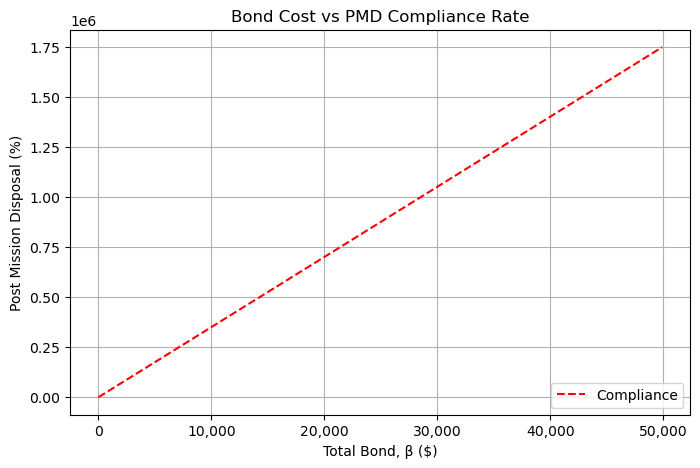

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define a formatter function
def comma_formatter(x, pos):
    return f'{int(x):,}'

# Define x-axis: Bond Cost ($) from 0 to 1,000,000 in increments of 100,000
bond_cost = np.arange(0, 50000, 100)

# Define the logistic-like compliance rate function
compliance_rate = 100 / (1 + np.exp(-0.00001 * (bond_cost - 500_000)))

# Define the exponential compliance rate function
def compliance_function_2(b):
    return 0.65 + 0.35 * (b)

# Compute values for the exponential function
compliance_rate_2 = compliance_function_2(bond_cost)

# Scale the exponential function to percentage terms
compliance_rate_2_scaled = compliance_rate_2 * 100

# Create the plot
plt.figure(figsize=(8, 5))
# plt.plot(bond_cost, compliance_rate, linestyle='-', color='b', label="PMD Compliance Rate (Logistic)")
plt.plot(bond_cost, compliance_rate_2_scaled, linestyle='--', color='r', label="Compliance")

# Labels and title
plt.xlabel(r"Total Bond, β ($)")
plt.ylabel("Post Mission Disposal (%)")
plt.title("Bond Cost vs PMD Compliance Rate")
# plt.ylim(60, 100)  # Keep y-axis limit slightly above 100% for clarity
plt.grid(True)
plt.legend(loc='lower right')

plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_formatter))

# Show the plot
plt.show()

# Naturally Compliant Orbits

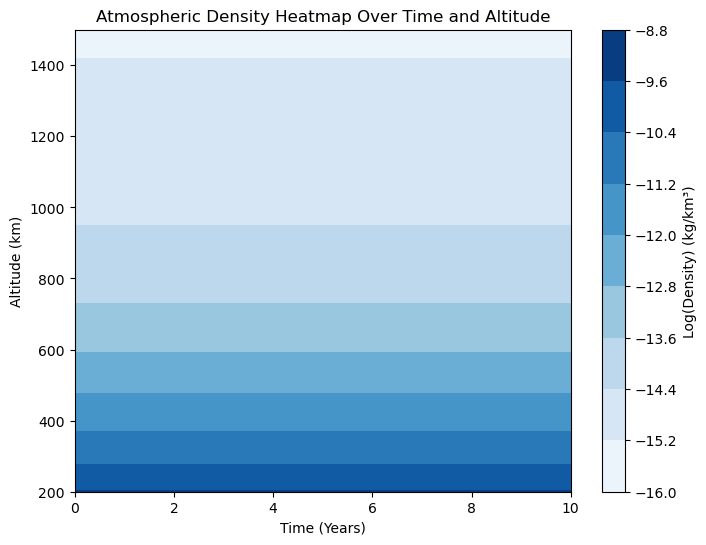

In [16]:
from pyssem.utils.drag.drag import densityexp

# Define time range (years) and altitude range (km)
years = np.arange(0, 11, 1)  # 10 years, yearly intervals
altitudes = np.arange(200, 1550, 50)  # 200 km to 1500 km, every 50 km
T, H = np.meshgrid(years, altitudes)


density_values = np.array([densityexp(altitudes)] * len(years)).T  # Repeat across time dimension

# Create the heatmap plot
plt.figure(figsize=(8, 6))
plt.contourf(T, H, np.log10(density_values), cmap="Blues")  # Log scale for better visualization

# Labels and title
plt.xlabel("Time (Years)")
plt.ylabel("Altitude (km)")
plt.title("Atmospheric Density Heatmap Over Time and Altitude")
cbar = plt.colorbar(label="Log(Density) (kg/km³)")

# Show the plot
plt.show()

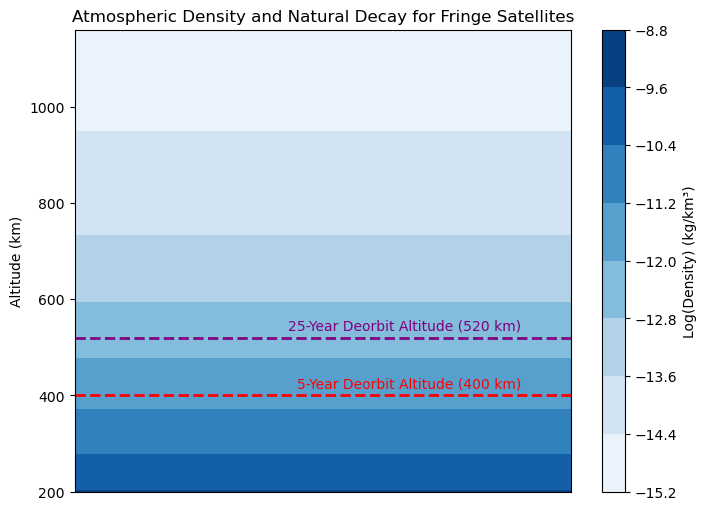

: 

In [ ]:
# Redefine necessary functions and imports since execution state was reset
import numpy as np
import matplotlib.pyplot as plt


# Define time range (years) and altitude range (km)
years = np.arange(0, 11, 1)  # 10 years, yearly intervals
altitudes = np.arange(200, 1200, 40)  # 200 km to 1500 km, every 50 km
T, H = np.meshgrid(years, altitudes)

# Compute cumulative residence times
cumulative_residence_times = [0.28545556713373055, 0.7610508871863472, 1.5483122423786122, 2.8346640378780457, 4.904346828559174, 8.20883936002697, 13.484900655514746, 21.76302754923995, 34.30522233406589, 53.30808243220308, 82.10011565363439, 122.39919379753357, 178.8047331717212, 257.7547518250079, 361.2956354851116, 492.739542786509, 659.6074404785045, 866.2185891684152, 1109.5646833299154, 1396.1795126959312, 1733.7647869288348, 2110.570434073066, 2531.1564926961883, 3000.6135532389762, 3524.6245264819395, 4109.533607580656, 4762.4232743662005, 5491.200256413817, 6304.6915206014455, 7212.751440841693, 8226.381455864086, 9357.863671010111, 10620.910029837094, 12030.828870980395, 13604.710897510642, 15361.636822528253, 17322.90921884735, 19512.311395558758, 21956.396453626843, 24684.810040488064]

cumulative_residence_times = np.array(cumulative_residence_times)
# Define disposal time thresholds in years
disposal_times = [5, 25]  # 5-year and 25-year deorbit thresholds

# Find the altitudes corresponding to these disposal times
altitudes_at_disposal = []
for disposal_time in disposal_times:
    idx = np.argmax(cumulative_residence_times >= disposal_time)  # Find first index exceeding disposal time
    if cumulative_residence_times[idx] < disposal_time:
        altitudes_at_disposal.append(None)  # If no valid altitude is found
    else:
        altitudes_at_disposal.append(altitudes[idx])

# Create the heatmap plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(T, H, np.log10(np.array([densityexp(altitudes)] * len(years)).T), cmap="Blues")  # Log scale

# Plot horizontal dashed lines for deorbit thresholds with different styles
line_styles = ['--', '--']  # Different dash styles
colors = ['red', 'purple']  # Different colors

for i, (disposal_time, altitude) in enumerate(zip(disposal_times, altitudes_at_disposal)):
    if altitude is not None:
        plt.axhline(y=altitude, color=colors[i], linestyle=line_styles[i], linewidth=2)
        plt.text(x=max(years) - 1, y=altitude + 10, s=f"{disposal_time}-Year Deorbit Altitude ({altitude} km)", 
                 color=colors[i], fontsize=10, verticalalignment='bottom', horizontalalignment='right')

# Labels and title
# Remove x axis ticks
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# plt.xlabel("Time (Years)")
plt.ylabel("Altitude (km)")
plt.title("Atmospheric Density and Natural Decay for Fringe Satellites")
plt.colorbar(contour, label="Log(Density) (kg/km³)")

# Show the plot
plt.show()

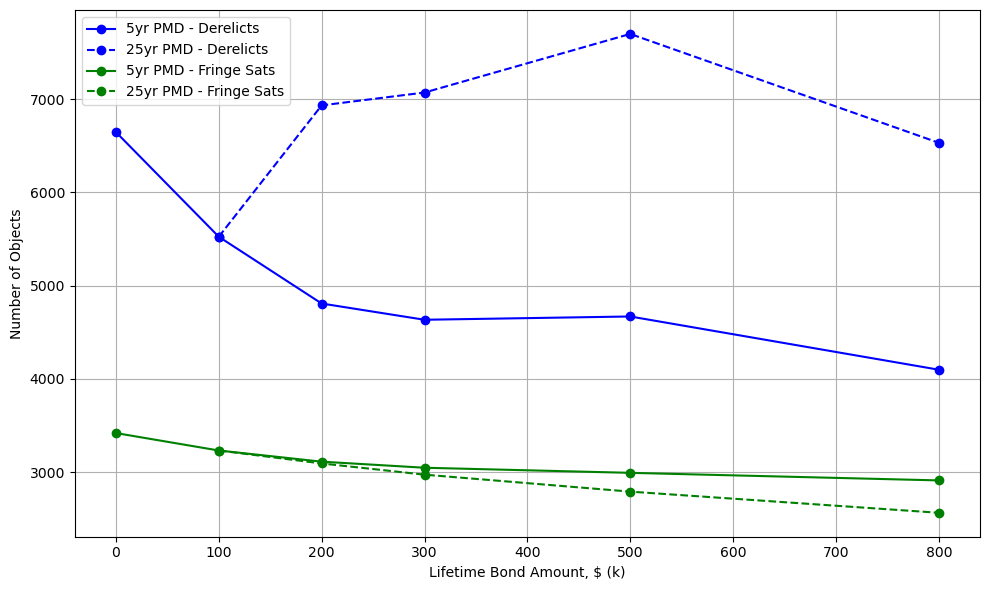

In [31]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt

# Set the root folder path
root_folder = r'C:\Users\IT\Documents\UCL\OPUS\Results\5yr_vs_25yr'

# Initialize lists for 5yr and 25yr PMD folders for each species
# For species "N_223kg"
bond_amounts_5yr_N = []
N_sums_5yr = []
bond_amounts_25yr_N = []
N_sums_25yr = []

# For species "Su"
bond_amounts_5yr_Su = []
Su_sums_5yr = []
bond_amounts_25yr_Su = []
Su_sums_25yr = []

# Baseline values (treated as 0k for 5yr)
baseline_N = None
baseline_Su = None

# Loop through each folder in root_folder
for folder_name in os.listdir(root_folder):
    folder_path = os.path.join(root_folder, folder_name)
    if not os.path.isdir(folder_path):
        continue

    # Check if this is the Baseline folder (case-insensitive)
    if folder_name.lower() == "baseline":
        species_data_file = None
        for f in os.listdir(folder_path):
            if f.startswith("species_data") and f.endswith(".json"):
                species_data_file = os.path.join(folder_path, f)
                break
        if species_data_file is None:
            print(f"Warning: No 'species_data' JSON found in Baseline folder. Skipping Baseline.")
        else:
            with open(species_data_file, "r") as infile:
                data = json.load(infile)
            # Expect the JSON to have both "N_223kg" and "Su"
            N_array = data.get("N_223kg")
            Su_array = data.get("Su")
            if N_array:
                baseline_N = sum(N_array[-1])  # sum of last row
            else:
                print("Warning: 'N_223kg' not found in Baseline JSON.")
            if Su_array:
                baseline_Su = sum(Su_array[-1])
            else:
                print("Warning: 'Su' not found in Baseline JSON.")
        continue  # Skip further processing for Baseline

    # Process folders for PMD scenarios: they should end with either "k" (5yr) or "25yr" (25yr)
    if os.path.isdir(folder_path) and (folder_name.endswith("k") or folder_name.endswith("25yr")):
        # Determine if this is a 25yr folder
        is_25yr = folder_name.endswith("25yr")
        # Extract bond amount from the folder name (e.g., 'bond_100k' or 'bond_100k_25yr' -> "100")
        match = re.findall(r'\d+', folder_name)
        if not match:
            print(f"Warning: Could not parse bond amount in folder: {folder_name}")
            continue
        bond_value = float(match[0])
        
        # Look for a JSON file starting with "species_data"
        species_data_file = None
        for f in os.listdir(folder_path):
            if f.startswith("species_data") and f.endswith(".json"):
                species_data_file = os.path.join(folder_path, f)
                break
        if species_data_file is None:
            print(f"Warning: No 'species_data' JSON found in {folder_path}. Skipping folder.")
            continue

        with open(species_data_file, "r") as infile:
            data = json.load(infile)

        # Extract final row sums for both species.
        # For "N_223kg":
        N_array = data.get("N_223kg")
        if not N_array:
            print(f"Warning: 'N_223kg' not found in {species_data_file}. Skipping folder.")
            continue
        final_N_sum = sum(N_array[-1])

        # For "Su":
        Su_array = data.get("Su")
        if not Su_array:
            print(f"Warning: 'Su' not found in {species_data_file}. Skipping folder.")
            continue
        final_Su_sum = sum(Su_array[-1])

        # Store values in the appropriate lists based on PMD type.
        if is_25yr:
            bond_amounts_25yr_N.append(bond_value)
            N_sums_25yr.append(final_N_sum)
            bond_amounts_25yr_Su.append(bond_value)
            Su_sums_25yr.append(final_Su_sum)
        else:
            bond_amounts_5yr_N.append(bond_value)
            N_sums_5yr.append(final_N_sum)
            bond_amounts_5yr_Su.append(bond_value)
            Su_sums_5yr.append(final_Su_sum)

# Define a helper function to sort paired lists by bond amount
def sort_by_bond(bonds, sums):
    paired = sorted(zip(bonds, sums), key=lambda x: x[0])
    if paired:
        bonds_sorted, sums_sorted = zip(*paired)
        return list(bonds_sorted), list(sums_sorted)
    else:
        return [], []

# Sort the PMD data for each species
bond_5yr_sorted_N, N_5yr_sorted = sort_by_bond(bond_amounts_5yr_N, N_sums_5yr)
bond_25yr_sorted_N, N_25yr_sorted = sort_by_bond(bond_amounts_25yr_N, N_sums_25yr)

bond_5yr_sorted_Su, Su_5yr_sorted = sort_by_bond(bond_amounts_5yr_Su, Su_sums_5yr)
bond_25yr_sorted_Su, Su_25yr_sorted = sort_by_bond(bond_amounts_25yr_Su, Su_sums_25yr)

# Incorporate Baseline into the 5yr data (if available)
if baseline_N is not None:
    bond_5yr_sorted_N.append(0)
    N_5yr_sorted.append(baseline_N)
    # Re-sort the list by bond amount
    paired_N = sorted(zip(bond_5yr_sorted_N, N_5yr_sorted), key=lambda x: x[0])
    bond_5yr_sorted_N, N_5yr_sorted = zip(*paired_N)
    bond_5yr_sorted_N, N_5yr_sorted = list(bond_5yr_sorted_N), list(N_5yr_sorted)

if baseline_Su is not None:
    bond_5yr_sorted_Su.append(0)
    Su_5yr_sorted.append(baseline_Su)
    # Re-sort the list by bond amount
    paired_Su = sorted(zip(bond_5yr_sorted_Su, Su_5yr_sorted), key=lambda x: x[0])
    bond_5yr_sorted_Su, Su_5yr_sorted = zip(*paired_Su)
    bond_5yr_sorted_Su, Su_5yr_sorted = list(bond_5yr_sorted_Su), list(Su_5yr_sorted)

# Create the plot
plt.figure(figsize=(10, 6))

# Set colors for each species (same for 5yr and 25yr)
color_N = "blue"
color_Su = "green"

# Plot 5yr PMD for "N_223kg" (solid line)
if bond_5yr_sorted_N:
    plt.plot(bond_5yr_sorted_N, N_5yr_sorted, marker='o', linestyle='-', color=color_N, label="5yr PMD - Derelicts")

# Plot 25yr PMD for "N_223kg" (dashed line, same color)
if bond_25yr_sorted_N:
    plt.plot(bond_25yr_sorted_N, N_25yr_sorted, marker='o', linestyle='--', color=color_N, label="25yr PMD - Derelicts")

# Plot 5yr PMD for "Su" (solid line)
if bond_5yr_sorted_Su:
    plt.plot(bond_5yr_sorted_Su, Su_5yr_sorted, marker='o', linestyle='-', color=color_Su, label="5yr PMD - Fringe Sats")

# Plot 25yr PMD for "Su" (dashed line, same color)
if bond_25yr_sorted_Su:
    plt.plot(bond_25yr_sorted_Su, Su_25yr_sorted, marker='o', linestyle='--', color=color_Su, label="25yr PMD - Fringe Sats")

plt.xlabel("Lifetime Bond Amount, $ (k)")
plt.ylabel("Number of Objects")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save or show the figure
plt.show()


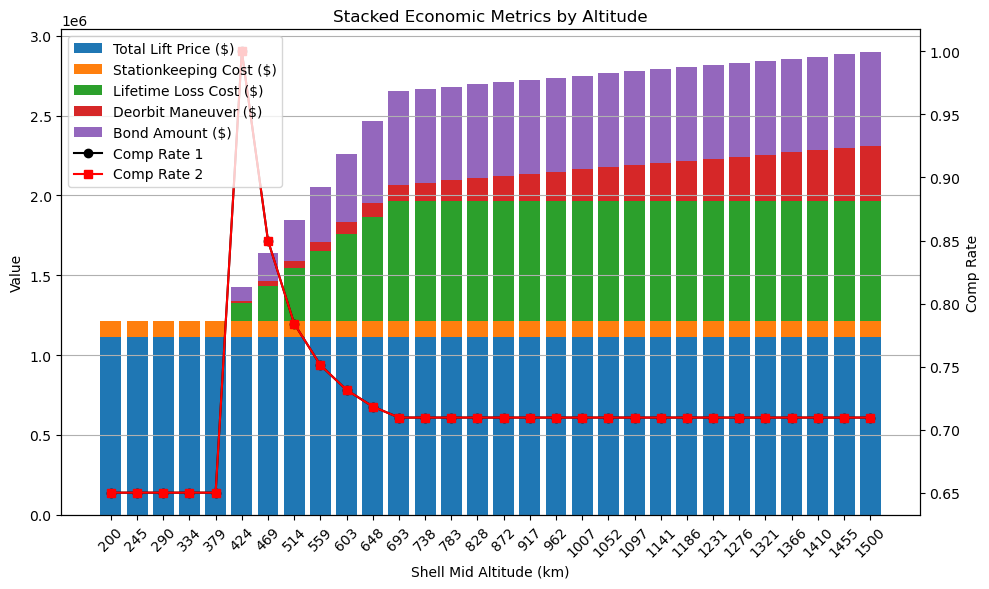

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# ----------------------------------------------------------------------------------
# 1) Define file path to your JSON file for stacked bar metrics and for comp_rate
# ----------------------------------------------------------------------------------
json_file = r"C:\Users\IT\Documents\UCL\OPUS\Results\5yr_vs_25yr\bond_200k\econ_params_bond_100k.json"
second_json_file = r"C:\Users\IT\Documents\UCL\OPUS\Results\5yr_vs_25yr\bond_100k\econ_params_bond_100k.json"

# ----------------------------------------------------------------------------------
# 2) Read the first JSON file into a Python dictionary (for stacked bars)
# ----------------------------------------------------------------------------------
with open(json_file, 'r') as f:
    econ_params = json.load(f)

# ----------------------------------------------------------------------------------
# 3) Read the second JSON file into a Python dictionary (for the additional comp_rate)
# ----------------------------------------------------------------------------------
with open(second_json_file, 'r') as f:
    econ_params_2 = json.load(f)

# ----------------------------------------------------------------------------------
# 4) Define the economic metrics you want to plot (from the first JSON file)
# ----------------------------------------------------------------------------------
metrics_info = [
    {"metric_key": "total_lift_price",      "label": "Total Lift Price ($)"},
    {"metric_key": "stationkeeping_cost",   "label": "Stationkeeping Cost ($)"},
    {"metric_key": "lifetime_loss_cost",    "label": "Lifetime Loss Cost ($)"},
    {"metric_key": "deorbit_maneuver_cost", "label": "Deorbit Maneuver ($)"},
    {"metric_key": "bstar",               "label": "Bond Amount ($)"}
]

# ----------------------------------------------------------------------------------
# 5) Define or retrieve the shell mid‐altitudes and set up the count
#    (Here, we create 30 shells from 200 to 1500 km)
# ----------------------------------------------------------------------------------
shell_mid_altitudes = np.linspace(200, 1500, num=30, endpoint=True)
n_shells = len(shell_mid_altitudes)

# ----------------------------------------------------------------------------------
# 6) Gather the metric arrays from the first JSON dictionary
# ----------------------------------------------------------------------------------
valid_metrics = []
valid_labels    = []

for info in metrics_info:
    key   = info["metric_key"]
    label = info["label"]

    arr = econ_params.get(key)
    # Check existence and lengths
    if arr is None:
        print(f"Warning: '{key}' not found in the JSON file. Skipping.")
        continue
    if not isinstance(arr, list):
        print(f"Warning: '{key}' must be a list in the JSON file. Skipping.")
        continue
    if len(arr) != n_shells:
        print(f"Warning: Length mismatch for '{key}' (expected {n_shells}, got {len(arr)}). Skipping.")
        continue

    valid_metrics.append(np.array(arr))
    valid_labels.append(label)

if not valid_metrics:
    print("No valid metrics found in the JSON file. Exiting.")
    exit()

# ----------------------------------------------------------------------------------
# 7) Create stacked bars using the data from the first JSON file
# ----------------------------------------------------------------------------------
x = np.array(shell_mid_altitudes)
num_metrics = len(valid_metrics)

# Determine a good bar width based on spacing
if len(x) > 1:
    x_spacing = x[1] - x[0]
    bar_width = 0.8 * x_spacing  # each bar is 80% of the spacing
else:
    bar_width = 0.4

bottom = np.zeros(n_shells)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Loop through each metric and create stacked bars
for i in range(num_metrics):
    metric = valid_metrics[i]
    label  = valid_labels[i]
    ax1.bar(x, metric, width=bar_width, bottom=bottom, label=label)
    bottom += metric

ax1.set_xlabel("Shell Mid Altitude (km)")
ax1.set_ylabel("Value")
ax1.set_title("Stacked Economic Metrics by Altitude")
ax1.set_xticks(x)
ax1.set_xticklabels([f"{val:.0f}" for val in x], rotation=45)
ax1.grid(True, axis='y')

# ----------------------------------------------------------------------------------
# 8) Add a second y-axis for 'comp_rate' from both JSON files (line plots)
# ----------------------------------------------------------------------------------
comp_rate_1 = econ_params.get("comp_rate", None)
comp_rate_2 = econ_params_2.get("comp_rate", None)

ax2 = ax1.twinx()  # create a second y-axis

# Plot first comp_rate if valid
if (comp_rate_1 is not None and isinstance(comp_rate_1, list) and len(comp_rate_1) == n_shells):
    ax2.plot(x, comp_rate_1, 'o-', color='black', label="Comp Rate 1")
else:
    print("Warning: 'comp_rate' from first JSON is missing or invalid.")

# Plot second comp_rate if valid
if (comp_rate_2 is not None and isinstance(comp_rate_2, list) and len(comp_rate_2) == n_shells):
    ax2.plot(x, comp_rate_2, 's-', color='red', label="Comp Rate 2")
else:
    print("Warning: 'comp_rate' from second JSON is missing or invalid.")

ax2.set_ylabel("Comp Rate")

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()

# ----------------------------------------------------------------------------------
# 9) Final step: Show or save the plot
# ----------------------------------------------------------------------------------
plt.show()